# Preparación del entorno

In [ ]:
!git clone https://github.com/josesanchfez-umu/k_brazos_SFDD.git
# Instalar librerías
!pip install numpy seaborn pandas matplotlib scikit-learn

In [ ]:
import os
os.chdir('k_brazos_SFDD')
print("Directorio actual:", os.getcwd())

In [ ]:
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src')


# Verificar que se han añadido correctamente
print(sys.path)

In [ ]:
import numpy as np
from typing import List

from algorithms import Algorithm
from algorithms.ucb1 import UCB1
from algorithms.ucb2 import UCB2
from arms.armnormal import ArmNormal
from arms import Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret

['C:\\Users\\Musatom\\miniconda3\\python312.zip', 'C:\\Users\\Musatom\\miniconda3\\DLLs', 'C:\\Users\\Musatom\\miniconda3\\Lib', 'C:\\Users\\Musatom\\miniconda3', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml', '', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\Pythonwin', './src/']


# Experimento

In [2]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

In [3]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos usando distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


En este experimento, al igual que pasaba con Bernoulli y de forma contraria al experimento con binomial, sí que hay cierta diferencia visible en las gráficas entre los pasos 500 y 1000, lo que es relevante a la hora de mantener los steps temporales en su valor de 1000 original.

# UCB1

In [4]:
# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
ucb1_algorithms = [UCB1(k, c=0.5), UCB1(k, c=1.0), UCB1(k, c=2.0)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_UCB1, optimal_selections_UCB1, arm_stats_UCB1, regret_accumulated_UCB1 = run_experiment(bandit, ucb1_algorithms, steps, runs)

## Recompensa promedio

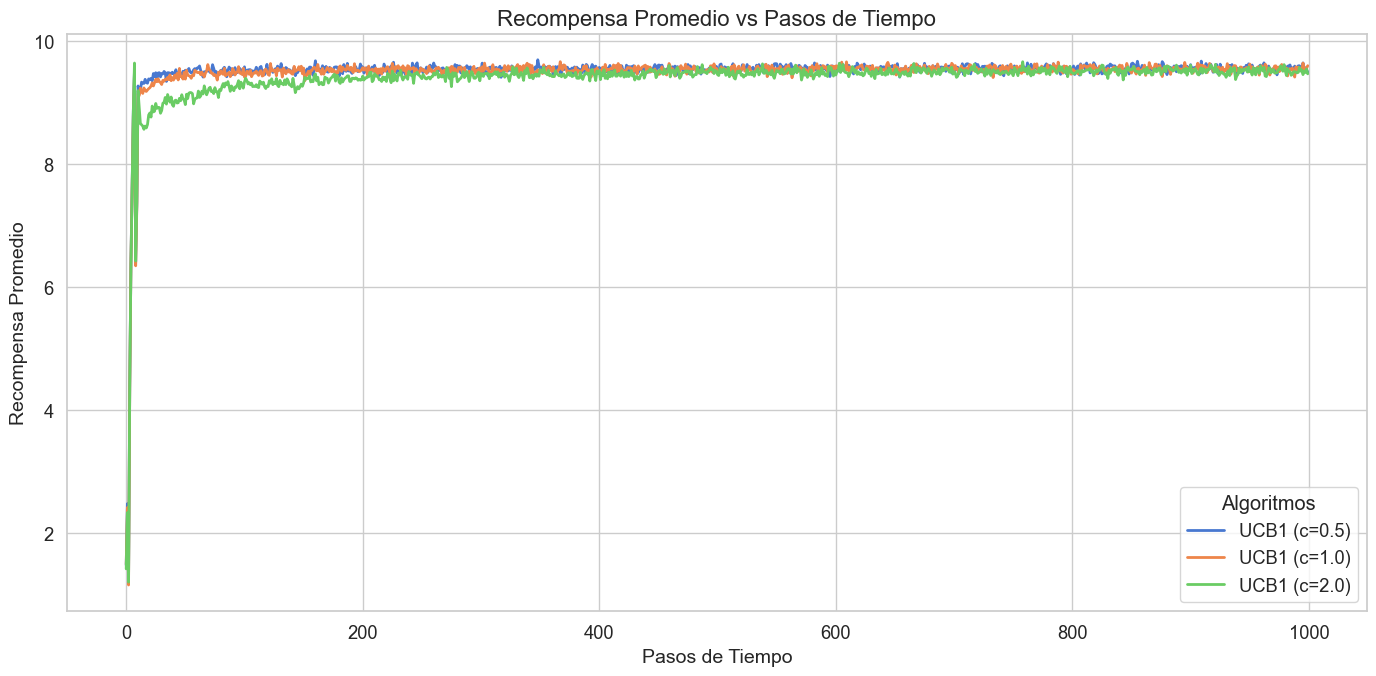

In [5]:
plot_average_rewards(steps, rewards_UCB1, ucb1_algorithms)

La gráfica anterior muestra la recompensa promedio obtenida por cada algoritmo en función del número de pasos. A nivel general, podemos indicar los siguientes hechos:

- Todas las variantes del algoritmo UCB1 (c=0.5, c=1.0 y c=2.0) convergen rápidamente hacia una recompensa promedio de aproximadamente 9.5. Esto sugiere que el algoritmo, independientemente del valor de c, logra identificar la mejor acción (o brazo) a lo largo del tiempo y maximizar la recompensa acumulada.

- Después de una fase inicial de fluctuaciones, todas las líneas se estabilizan y siguen una tendencia similar. Esto indica que, si bien c tiene un efecto en las fases iniciales, su impacto a largo plazo parece ser menos significativo en este experimento, similar a otros con distribución normal.

- Hemos mantenido en este estudio los steps temporales de 1000, ya que la gráfica muestra variaciones en el fragmento que va desde el paso 500 al 1000, lo que permite visualizar mejor las diferencias entre las variantes del algoritmo, como se menciona en el apartado "Experimento".

**Resultados por algoritmo**

- La línea verde (c=2.0) muestra fluctuaciones iniciales más significativas, lo cual indica que con un mayor c, el algoritmo tiende a explorar más al principio antes de estabilizarse.

- Las líneas azul (c=0.5) y naranja (c=1.0) muestran un comportamiento más estable desde el principio, lo que podría sugerir una menor exploración inicial y, por consiguiente, un mejor resultado.

Dado que el experimento consiste en visualizar el rendimiento general obtenido por las variantes del mismo algoritmo, podemos decir que, nuevamente, es más efectivo priorizar la explotación sobre la exploración, ya que los valores bajos del factor de exploración logran un mejor desempeño final.

## Regret acumulado

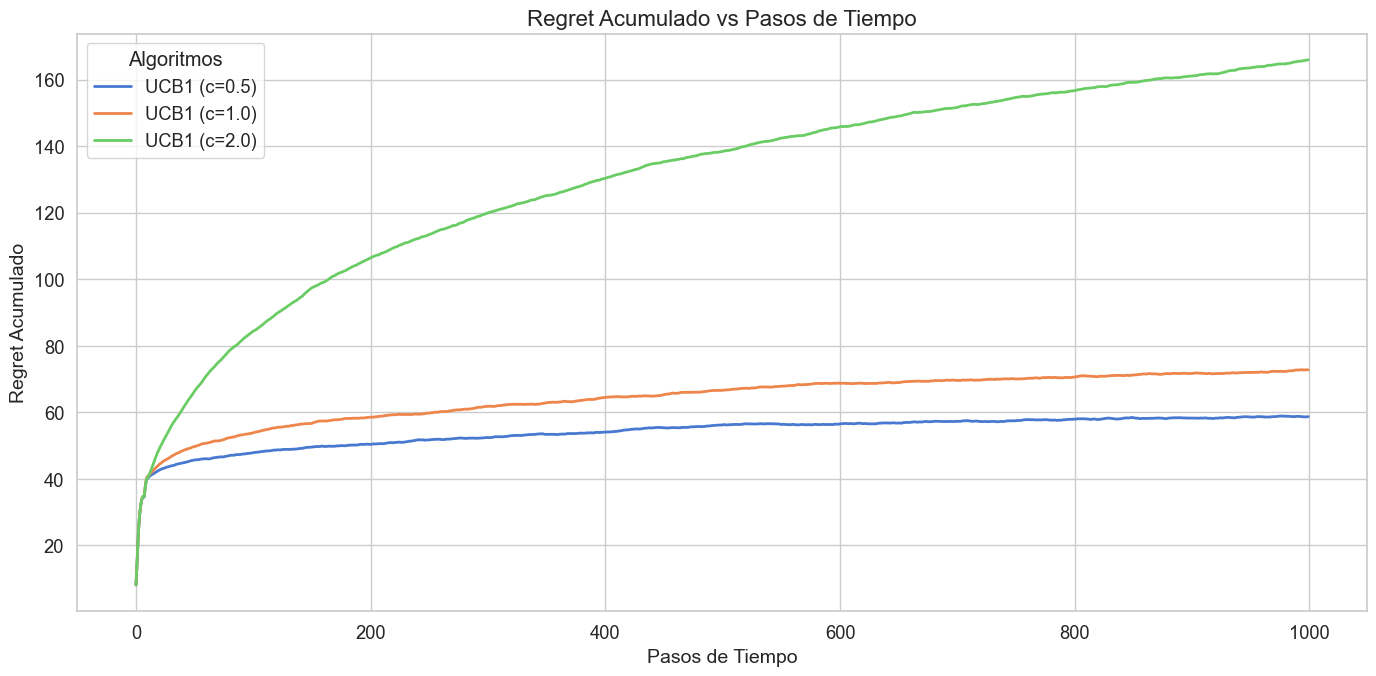

In [6]:
plot_regret(steps, regret_accumulated_UCB1, ucb1_algorithms)

La gráfica anterior muestra el regret acumulado obtenido por cada algoritmo en función del número de pasos. A nivel general, podemos indicar los siguientes hechos:

- Todas las variantes del algoritmo UCB1 (c=0.5, c=1.0 y c=2.0) muestran un crecimiento constante en el regret acumulado a lo largo del tiempo. Sin embargo, el ritmo y el valor final del regret acumulado varían significativamente entre las variantes, indicando un impacto considerable del parámetro c en la eficiencia del algoritmo.

- A medida que aumenta el número de pasos, el regret acumulado para cada variante se estabiliza en una tasa de crecimiento más uniforme, lo que sugiere que cada algoritmo encuentra un equilibrio entre exploración y explotación en las últimas etapas.

**Resultados por algoritmo**

- La línea verde (UCB1 con c=2.0) muestra el regret acumulado más alto a lo largo del experimento. Esto indica que esta variante prioriza significativamente la exploración inicial, lo que lleva a una acumulación de regret más rápida y consistente.

- La línea naranja (UCB1 con c=1.0) se encuentra en un punto intermedio, mostrando un compromiso entre exploración y explotación. Si bien acumula menos regret que la variante con c=2.0, sigue estando por encima de la línea correspondiente a c=0.5.

- La línea azul (UCB1 con c=0.5) tiene el menor regret acumulado en comparación con las otras variantes. Esto sugiere que priorizar la explotación desde etapas tempranas del experimento resulta en una menor penalización acumulada.

Dado que el experimento se centra en analizar cómo el parámetro c afecta el regret acumulado, podemos concluir que valores bajos de este factor (como c=0.5) son más efectivos en minimizar el regret, probablemente debido a una menor propensión a explorar acciones subóptimas. Sin embargo, esto también podría ser a costa de una menor adaptabilidad a entornos con cambios dinámicos.

## Optimal selections

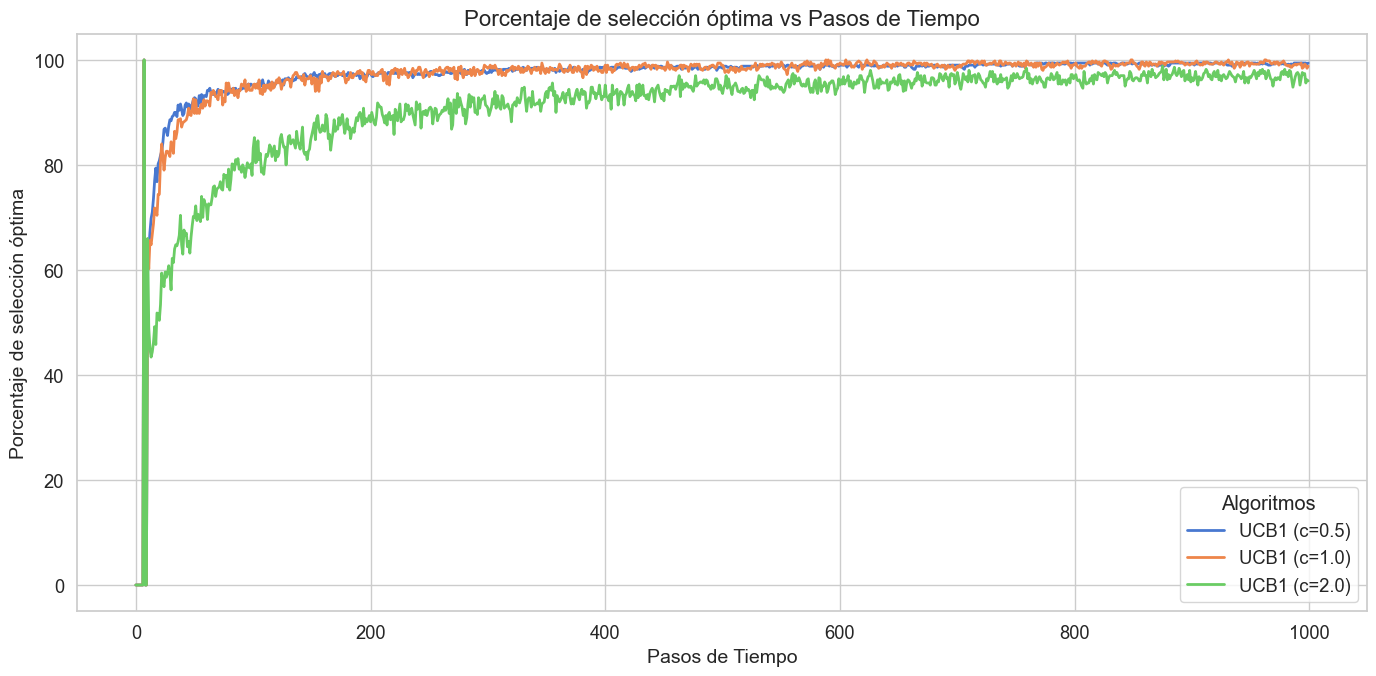

In [7]:
plot_optimal_selections(steps, optimal_selections_UCB1, ucb1_algorithms)

La gráfica anterior muestra el porcentaje de selección del brazo óptimo obtenido por cada algoritmo en función del número de pasos. A nivel general, podemos indicar los siguientes hechos:

- Todas las variantes del algoritmo incrementan gradualmente el porcentaje de selección del brazo óptimo a medida que avanzan los pasos de tiempo. Sin embargo, la velocidad con la que alcanzan un porcentaje alto, así como el valor final estabilizado, es diferente entre las variantes.

- Tanto las líneas azul (c=0.5) como naranja (c=1.0) alcanzan rápidamente un porcentaje cercano al 100% de selección del brazo óptimo y permanecen estables en este nivel a lo largo del tiempo. Esto indica una capacidad más efectiva de estas variantes para identificar y explotar la mejor opción disponible.

- Por otro lado, la línea verde (c=2.0) también muestra un incremento en la selección del brazo óptimo, pero no logra alcanzar el nivel de las otras dos variantes, estabilizándose en un porcentaje notablemente más bajo. Esto refleja una tendencia hacia una mayor exploración que compromete la eficacia a largo plazo en términos de selección óptima.

**Resultados por algoritmo**

- UCB1 con c=0.5: Alcanza el 100% de selección del brazo óptimo en menos pasos, destacándose como la variante más eficiente en este experimento.

- UCB1 con c=1.0: También logra un excelente rendimiento, alcanzando el 100%, aunque con una ligerísima diferencia temporal respecto a la variante con c=0.5.

- UCB1 con c=2.0:, Aunque mejora con el tiempo, se estabiliza en un porcentaje inferior al 100%, lo que sugiere una exploración más prolongada que penaliza la selección óptima a largo plazo.

Dado que el experimento consiste en analizar la capacidad de cada variante para identificar y seleccionar consistentemente el brazo óptimo, podemos concluir que los valores más bajos del parámetro c (como c=0.5) son más efectivos en maximizar este porcentaje, reafirmando la tendencia observada en estudios anteriores. Sin embargo, esta ventaja podría perderse en escenarios más dinámicos donde se requiere adaptabilidad.

# UCB2

In [8]:
# Definir los algoritmos a comparar. Ahora usamos el otro algoritmo pedido de la familia UCB: UCB2, con diferentes valores del parámetro de ajuste de exploración alpha.
ucb2_algorithms = [UCB2(k, alpha=0.01), UCB2(k, alpha=0.1), UCB2(k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_UCB2, optimal_selections_UCB2, _, regret_accumulated_UCB2 = run_experiment(bandit, ucb2_algorithms, steps, runs)

## Recompensa promedio

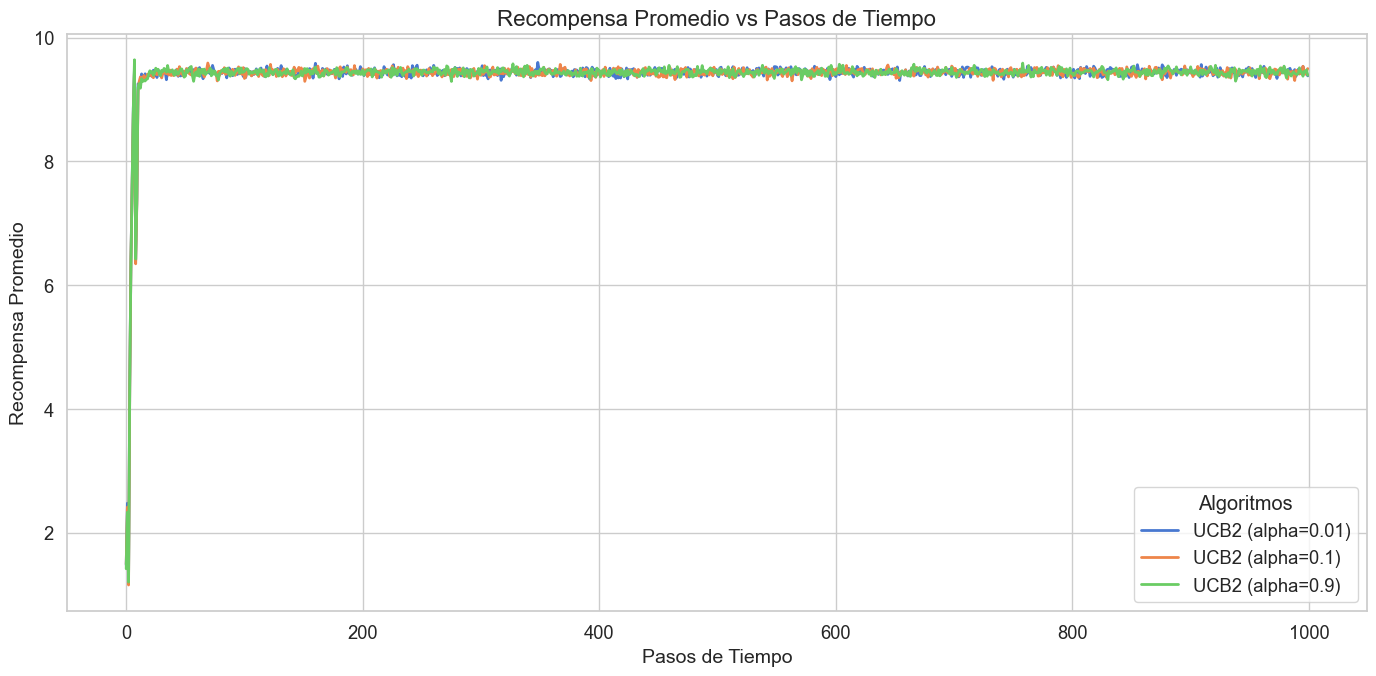

In [15]:
plot_average_rewards(steps, rewards_UCB2, ucb2_algorithms)

La gráfica que mostramos en este apartado es similar a la mostrada para UCB1, pero variando el valor de alpha en el algoritmo UCB2. Ocurre exactamente lo mismo que en el experimento con distribución binomial, en el que el algoritmo UCB2 presentaba unos resultados prácticamente exactos para todas sus variables.

Al igual que en el otro experimento, inicialmente hay algunas irregularidades pero, a los pocos steps, las tres variantes alcanzan un promedio de alrededor de 9.5, que es la recompensa óptima en este caso. Solo queda mencionar que las tres líneas se mantienen completamente estables en dicho promedio desde el mismo momento en el que lo alcanzan, y por ello, podemos afirmar que el valor de alpha no influye a la hora de obtener un valor de recompensa decente.

## Regret acumulado

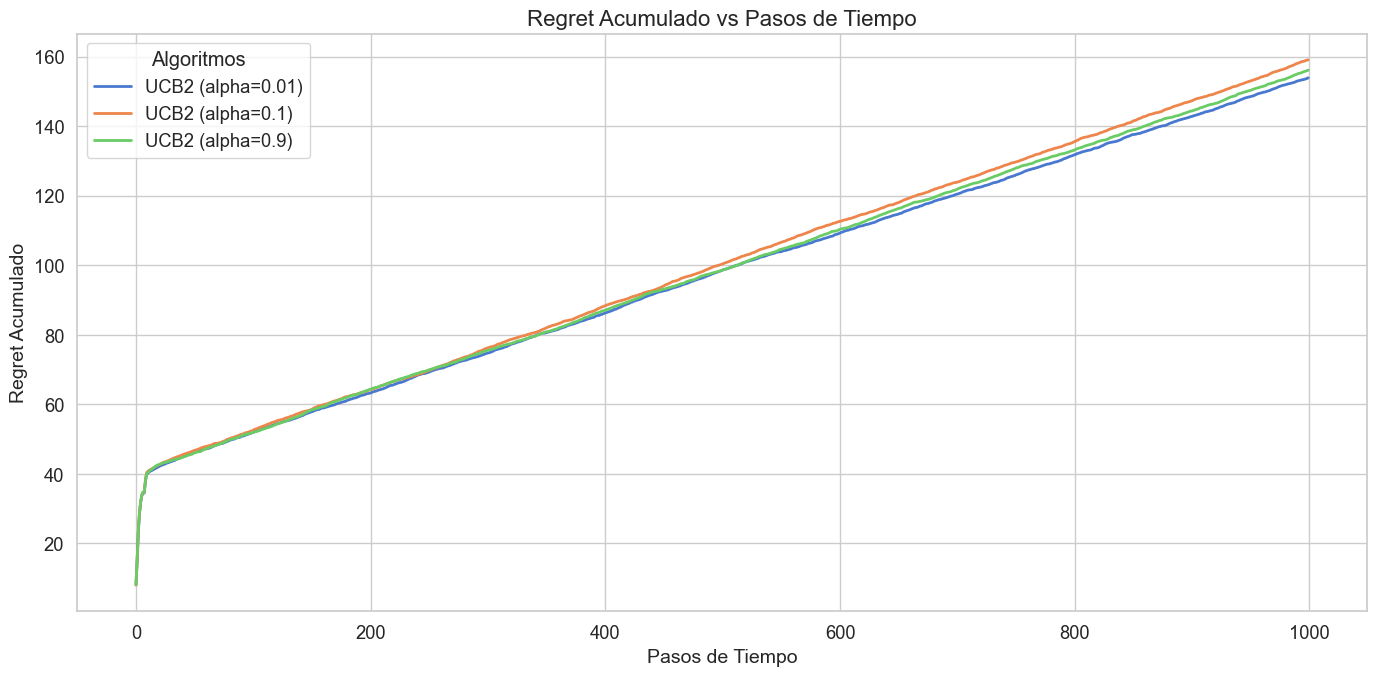

In [16]:
plot_regret(steps, regret_accumulated_UCB2, ucb2_algorithms)

La gráfica que mostramos en este apartado es similar a la mostrada para UCB1, pero variando el valor de alpha en el algoritmo UCB2. Ocurre exactamente lo mismo que en el experimento con distribución binomial, en el que el algoritmo UCB2 presentaba unos resultados prácticamente equivalentes para todas sus variantes. Inicialmente hay un crecimiento masivo debido a la explotación de brazos no óptimos, pero, a los pocos steps, las tres variantes alcanzan un ritmo de crecimiento constante y uniforme en el regret acumulado. Esto indica que el rendimiento del algoritmo es poco sensible a los diferentes valores de alpha utilizados en el experimento.

Finalmente, comentar que las líneas muestran un comportamiento estable y una tendencia casi idéntica una vez que superan las fases iniciales. Por ello, podemos afirmar que el valor de alpha no influye significativamente en la acumulación de regret a largo plazo para el algoritmo UCB2.

## Optimal selections

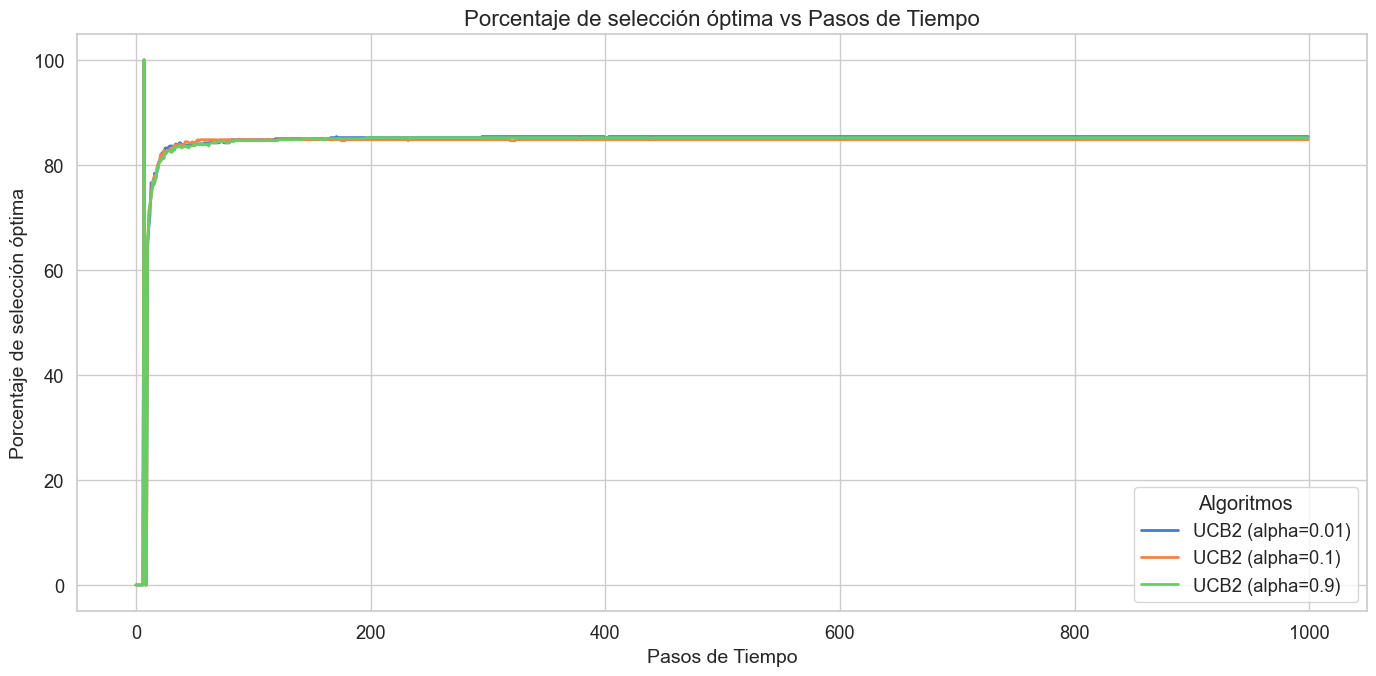

In [11]:
plot_optimal_selections(steps, optimal_selections_UCB2, ucb2_algorithms)

En la gráfica de este apartado vemos una situación muy parecida a la de la recompensa promedio, en la que, a pesar de unos valores extremos alcanzados al inicio, a los pocos steps tiene lugar un crecimiento muy grande y una rapdisíma estabilización de las tres curvas, manteniéndose completamente rectas una vez estabilizadas. Lo que nos indica esto es que aunque aumentemos el valor de exploración, la toma de decisiones no mejora en lo absoluto, y, además, no empeora, por lo que es completamente irrelevante dicho valor en este aspecto.

# UCB1 vs UCB2

## Recompensa promedio

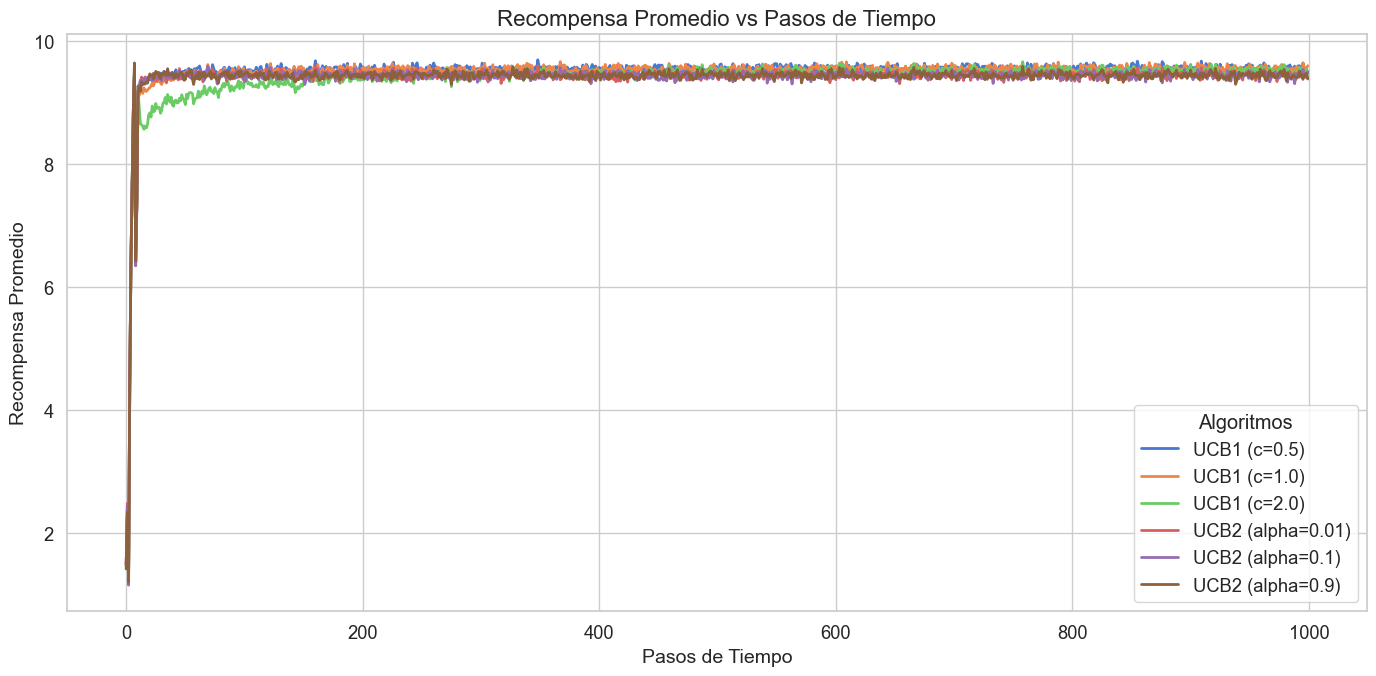

In [12]:
plot_average_rewards(steps, np.vstack((rewards_UCB1, rewards_UCB2)), ucb1_algorithms+ucb2_algorithms)

La gráfica que mostramos en este apartado compara las variantes del algoritmo UCB1 y UCB2 en cuanto a la recompensa promedio obtenida en función del tiempo. Ocurre algo similar a lo observado en experimentos previos: todas las variantes logran eventualmente aproximarse al mismo valor de recompensa promedio.

Concretamente, en el caso de las variantes de UCB1, muestran comportamientos iniciales diferentes, con fluctuaciones más significativas en la variante c=2.0 debido a una mayor exploración. Sin embargo, todas convergen de manera estable hacia el mismo valor final de recompensa promedio.

En este caso, todas las variantes tanto de UCB1 como de UCB2 convergen rápidamente a una recompensa promedio cercana a 10, que es el valor óptimo en este experimento. Aunque presentan ligeras diferencias en las fases iniciales, estas son menos pronunciadas a medida que aumenta el número de pasos, por lo que podemos afirmar que tanto el valor de c en UCB1 como el valor de alpha en UCB2 tienen un impacto mayoritariamente en las fases iniciales de los experimentos. A largo plazo, los algoritmos logran una recompensa promedio óptima de forma consistente, independientemente de las variantes utilizadas.

## Regret acumulado

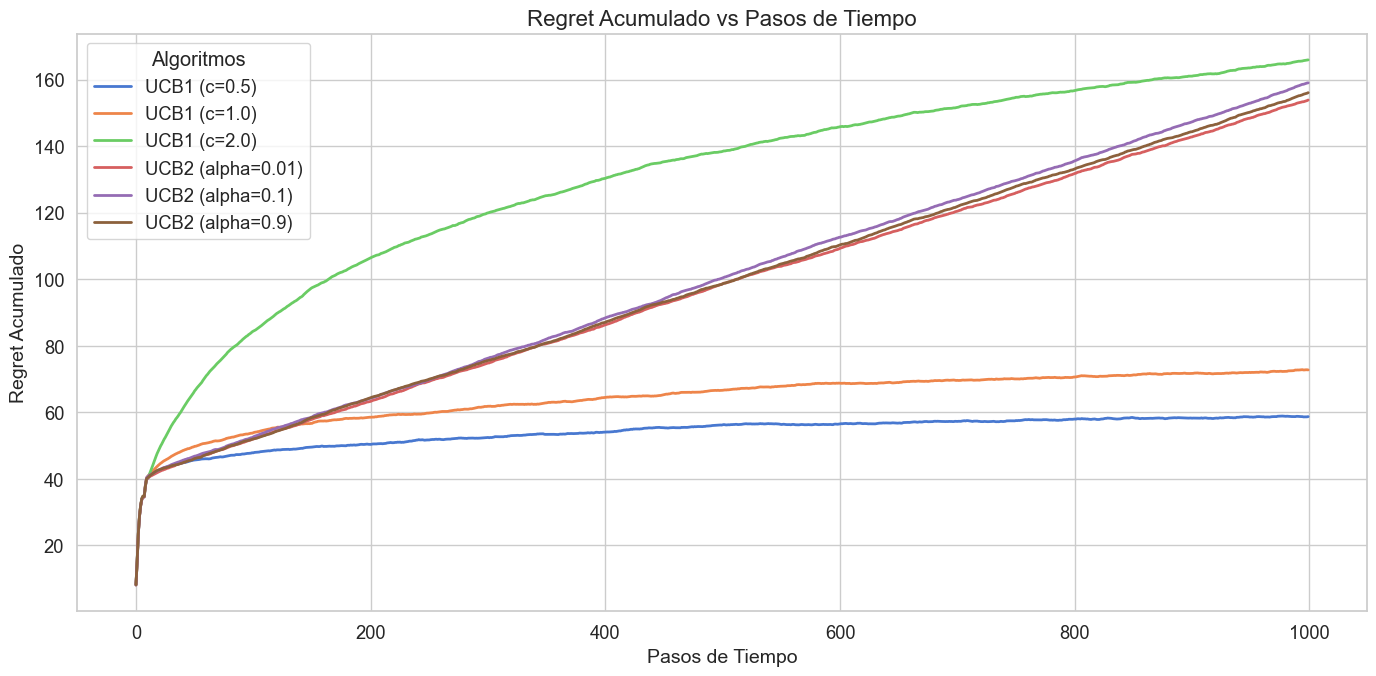

In [13]:
plot_regret(steps, np.vstack((regret_accumulated_UCB1, regret_accumulated_UCB2)), ucb1_algorithms+ucb2_algorithms)

En este experimento, UCB1 generalmente logra un menor regret acumulado en comparación con UCB2. Esto se debe a que UCB1 ajusta más rápidamente el equilibrio entre exploración y explotación, lo cual minimiza el tiempo desperdiciado en acciones subóptimas, mientras que UCB2 puede acumular más regret por no adaptarse tan rápido en entornos en los que una acción óptima es claramente mejor que el resto desde el principio.

UCB1 tiende a ser más efectivo en entornos donde la identificación del brazo óptimo se puede lograr rápidamente, mientras que UCB2 sacrifica rendimiento inicial por una exploración más metódica. Además, el parámetro c de UCB1 parece tener un mayor impacto en el regret acumulado en comparación con el parámetro alpha de UCB2.

## Optimal selections

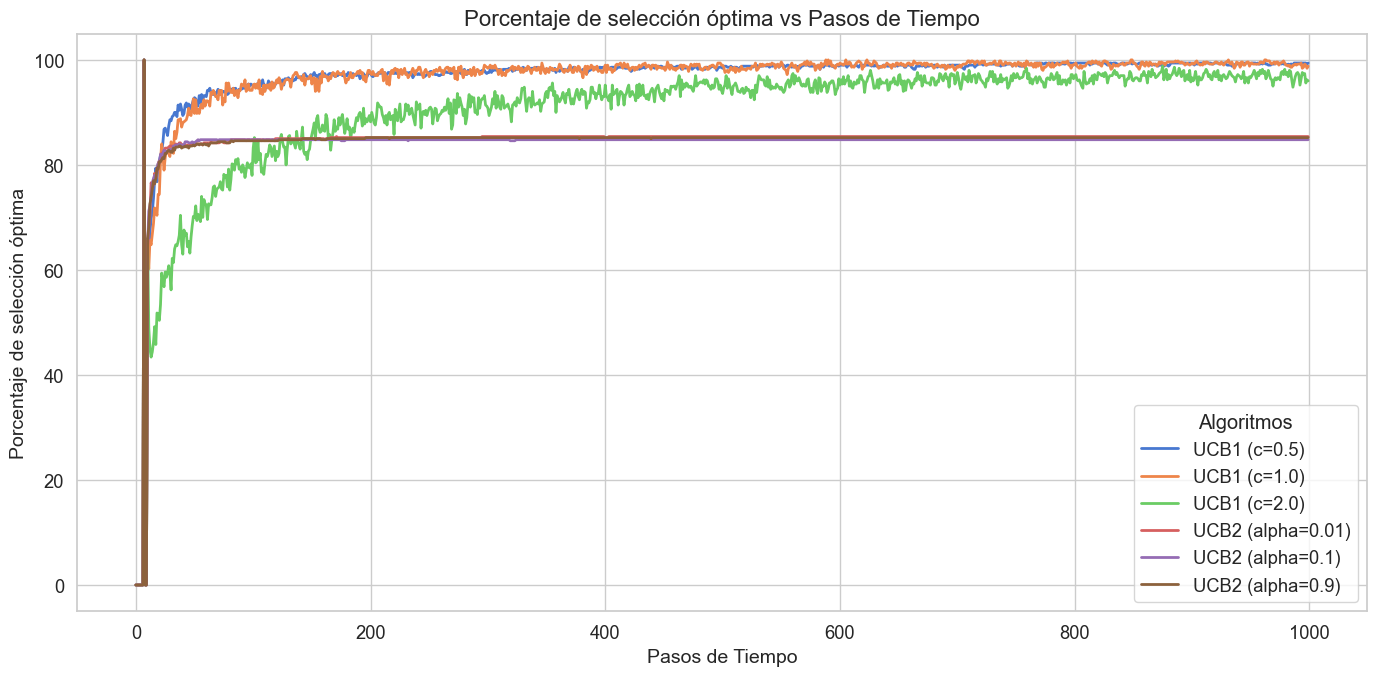

In [14]:
plot_optimal_selections(steps, np.vstack((optimal_selections_UCB1, optimal_selections_UCB2)), ucb1_algorithms+ucb2_algorithms)

La gráfica que mostramos en este apartado compara el porcentaje de selección del brazo óptimo entre las variantes de UCB1 y UCB2 en función del número de pasos. Los resultados revelan diferencias importantes entre ambos algoritmos, especialmente en su rapidez para alcanzar niveles altos de selección óptima y en su comportamiento estable a largo plazo.

Las variantes de UCB1 alcanzan un porcentaje de selección óptima cercano al 100% de manera más algo más lenta que las variantes de UCB2. Esto nos indica que, en un determinado momento, UCB1 se adapta mejor que UCB2 a la toma de decisiones del problema definido en este experimento.

A largo plazo, la estabilidad de UCB2 es mayor, aunque la resultante de las líneas representativas de UCB1 es bastante buena también, y además lo logra en un valor muy cercano al 100%, consiguiendo un porcentaje de selección casi perfecto, especialmente en los valores más bajos de exploración.

Por tanto, podemos concluir que UCB1 es algo más eficiente que UCB2 en el contexto de este problema y dado el empleo de la distribución normal, contando con las diferencias visibles en las dos últimas gráficas, ya que en cuanto a recompensa promedio obtenida, todas las variantes obtienen resultados más que aceptables.